In [16]:
%matplotlib inline

In [17]:
import tensorflow as tf
import os
from os.path import splitext
from tensorflow.contrib.framework.python.ops import audio_ops
import numpy as np
import soundfile as sf
import sounddevice as sd
from matplotlib.widgets import Button
import matplotlib.pyplot as plt
import re
from scipy import signal
from scipy import misc
from scipy import stats
from scipy import ndimage
from scipy import interpolate
import scipy.io.wavfile
import matplotlib.image as mpimg
import pandas as pd

In [18]:
tf.enable_eager_execution() 
#tf.disable_eager_execution()

In [19]:
def LoadToSpectrogram(wav_file,window_size = 1024,stride=64):
    """Load audio file, return spectrogram,rate,and waveform
    
    accepts either mp3 or flac. Not tested on other formats.
    
    window_size hard coded at 1024, stride at 64
    
    """
    proot,pext = os.path.splitext(wav_file)
    if "mp3" in pext.lower():
        song_binary = tf.read_file(wav_file) # expecting all my mp3 files to fit this format, eg only from Cornell database
        song_waveform = tf.contrib.ffmpeg.decode_audio(song_binary,file_format='mp3',samples_per_second=48000,channel_count=1)
        np_song_waveform = song_waveform.numpy()[0]
        rate = 48000
    else:    
        np_song_waveform,rate = sf.read(wav_file,always_2d=True,dtype='float32')
        song_waveform = tf.convert_to_tensor(np_song_waveform)
    spectrogram = audio_ops.audio_spectrogram(song_waveform,window_size=window_size,stride=stride)
    return spectrogram,rate,np_song_waveform,window_size,stride

In [20]:
def snip_up_spectrogram(specnum,min_extent = 50,min_amplitude = 0.3,pad = 10,debug=False):
    """ locate and return features in spectrogram, and their locations in the original 
    
    Arguments
        specnum: a numpy array shape (n,m)
    Keywork Argument
        min_extent: do not return segments shorter than this
        min_amplitude: do not return snips quieter than this. Since they are normalized to local peaks, 
                        very low amplitude signals (oftern other birds) can be hard
        pad: add to width of the thresholded slice 
    
    """
    filta,filtb = signal.iirdesign(0.004,0.5,1,20)
    def tmeanmid(a) :
        midmax = np.max(a)/3.5
        return stats.tmean(a,(midmax,None))
    step_kernel = np.zeros(101)
    step_kernel_width = 40
    step_kernel[:] = -0.1
    step_kernel[50-40:50+40] = 1.0
    km = np.sum(step_kernel)
    step_kernel = step_kernel / km

    maxima = np.apply_along_axis(tmeanmid,1,specnum)
    filtered_maxima = signal.convolve(maxima,step_kernel,mode='same')
    over_filtered_maxima = signal.filtfilt(filta,filtb,filtered_maxima)
    
    
    peak_indicis,peak_properties = signal.find_peaks( over_filtered_maxima,width = (4,1000),height=(0.06,10))
    my_peak_value = np.ones(np.shape(maxima)[0])
    widths = peak_properties['widths']
    for pin,pw in zip(peak_indicis,widths):
        my_peak_value[pin-int(pw):pin+int(pw)] = filtered_maxima[pin]
    
    gate = filtered_maxima/my_peak_value>0.3
    pillars = np.cumsum(1-gate)*gate
    
    startextents = np.transpose(np.unique(pillars,return_counts=True,return_index=True))
    if debug:
        print(np.shape(startextents))
    snip_extents = []
    snips = []
    if debug:
        print(np.shape(specnum))
    for pair in startextents:
        if (pair[0]!=0) and (pair[2]>min_extent):
            start = max(0,pair[1]-pad)
            end = min(pair[1]+pair[2]+pad,np.shape(specnum)[0])
            snips.append(specnum[start:end])
            snip_extents.append((pair[0],start,end))
    return snips,snip_extents   

In [21]:
def MakeGreyFromSnip(snip,crop_len = 512,imsize = 512,imwidth = None,low_log_bound = 1.2):
    """ make a gray scale numpy image from a spectrogram
    
    Arguments
        snip: spectrogram as 2D numpy array
        
    Keyword arguments
        crop_len:  
            If the snip exceeds this length, crop to it. 
            If the snip is shortr than this length, pad with zeros 
        imsize:
            Resize the image to this size in pixels
        imwidth:
            If imwidth is not specified, make the image square, else image is (imsize,imwidth)
        low_log_bound:
            spectrogram is nomalized to 1e4, then converted to log10, to give a range from _ to 4
            the lower bound is then clipped to 'low_log_bound'
            and then shifted to fill the new range
            In the resulting image, 
                0 maps to 10^low_log_bound, 
                1 maps to 10^4
                
    """
    len = np.shape(snip)[0]
    pad_n = crop_len - len
    if pad_n<0:
        pad_n=0
    snipMax = np.max(snip)
    snip_nz = np.maximum(snip,np.power(10,low_log_bound-4))
    log_norm_snip = np.log10(10000.*snip_nz/snipMax)
    snappedf = np.transpose(np.pad(log_norm_snip[0:crop_len,:],((0,pad_n),(0,0)),mode='constant'))
    snapped = np.maximum(snappedf,low_log_bound) - low_log_bound
    spmax = np.max(snapped)
    snapped_norm_tensor = tf.convert_to_tensor(snapped / spmax)
    sne = tf.expand_dims(tf.expand_dims(snapped_norm_tensor,0),3)
    _imwidth = imsize
    if imwidth is not None:
        _imwidth = imwidth
    resize = tf.image.resize_bilinear(sne,[imsize,_imwidth])
    return resize.numpy()[0,:,:,0]
    

In [22]:
songs_dir_path="/home/roberta/Documents/Birds/CornellGuidetoBirdSounds_EssentialSetforNorthAmerica_2014/"
brit_dir_path = "/home/roberta/Documents/Birds/British-birdsong-dataset/"
snip_spectra_dir_path = "/home/roberta/Documents/Birds/spectraSnips/"
snip_wav_dir_path = "/home/roberta/Documents/Birds/wavSnips/"
britCSV = brit_dir_path+"birdsong_metadata.csv"
#/home/roberta/Documents/Birds/csvDatabase/CornellClassify.csv
cornellCSV = "/home/roberta/Documents/Birds/csvDatabase/CornellClassify.csv"
snip_db_CSV = "/home/roberta/Documents/Birds/csvDatabase/snips.csv"
song_list = tf.gfile.ListDirectory(songs_dir_path)
song = song_list[148]

In [23]:
tx = pd.read_csv(britCSV,header=0,usecols=['file_id','english_cname','genus','species'])
snip_db = pd.DataFrame(columns=['common_name','origin_database','genus','species','snip_id','snip_length','snip_mean_amplitude','wav_path','wav','spectra_path'])
cornellMeta = pd.read_csv(cornellCSV)
# cornellMeta.head() # created via filling named, so expect those columns
# also, Cornell species is actually genus + " " + species
tx.head()

,file_id,genus,species,english_cname
0,132608,Acanthis,flammea,Common Redpoll
1,132611,Acanthis,flammea,Common Redpoll
2,35068,Acanthis,flammea,Common Redpoll
3,82715,Acrocephalus,palustris,Marsh Warbler
4,64685,Acrocephalus,palustris,Marsh Warbler


In [24]:
cornellMeta.head()

,Unnamed: 0,common_name,order,family,genus,species,file_name,spectrum_name
0,1281,Scissor-tailed Flycatcher,Passeriformes,Tyrannidae,Tyrannus,Tyrannus forficatus,Scissor-tailed Flycatcher 1 Song and calls.mp3,Scissor-tailed Flycatcher 1 Song and calls.png
1,1403,Fish Crow,Passeriformes,Corvidae,Corvus,Corvus ossifragus,Fish Crow 1 Calls.mp3,Fish Crow 1 Calls.png
2,1001,Aplomado Falcon,Falconiformes,Falconidae,Falco,Falco femoralis,Aplomado Falcon 1 Calls.mp3,Aplomado Falcon 1 Calls.png
3,411,King Rail,Gruiformes,Rallidae,Rallus,Rallus elegans,King Rail 1 Male advertisement kek calls.mp3,King Rail 1 Male advertisement kek calls.png
4,470,Whimbrel,Charadriiformes,Scolopacidae,Numenius,Numenius phaeopus,Whimbrel 2 Calls and song.mp3,Whimbrel 2 Calls and song.png


In [25]:
def resample(specnum,rate_in,rate_out):
    width = np.shape(specnum)[1]
    length = np.shape(specnum)[0]
    res = np.zeros(np.shape(specnum))
            # lets see.. frequency represented by point N in input is rate_in (ok ok, at point 2N it is. Whats importatnt is the ratio)
            # and I want point N in the output to represent rate_out. So rate_out/rate_inabs 
    out_freqs = np.array(range(width))*rate_out / rate_in
    in_freqs = np.array(range(width))
    for slice_n in range(length):
        f = interpolate.interp1d(in_freqs,specnum[slice_n,:],kind=2,fill_value="extrapolate")
        res[slice_n,:] = f(out_freqs)
    return res

In [26]:
def load_snip_to_db(dir_path, file_name, snip_db, common_name, genus, species, origin_database,debug=False):
    
    spectrogram,rate,wavnum,window_size,stride = LoadToSpectrogram(dir_path+file_name)
    specnum = spectrogram.numpy()[0]
    file_name_root = splitext(file_name)[0]
# had chosen a frequency range from [:,20:300] at rate=48000
# if the rate is different, what should the range be?
# 512 samples, f[511] = rate / 2
# f_step - rate / 2 *512, rate / 1024
   # ftop = 300 * 48000 / 1024
   # fbot = 20 * 48000 / 1024
   # Ntop = int(ftop * 1024 / rate)
   # Nbot = int(fbot * 1024 / rate)
   # nope nope. resample the spectrum, to get align exact
   # 7/9/19 changed range to 19:300
    effective_stride = stride
    effective_window_size = window_size
    if rate != 48000:
        if debug:
            print("resampling")
        corrected_specnum = resample(specnum,rate,48000)
        effective_window_size *= rate/48000
        effective_stride *= rate/48000
        if debug:
            print("resampled")
    else:
        corrected_specnum = specnum
    mean_of_spectrogram = np.mean(corrected_specnum[:,19:300])  
    snips,stext = snip_up_spectrogram(corrected_specnum[:,19:300],min_extent=50,debug=True)
    snipi = 0
    for snip,sext in zip(snips,stext):
        snip_length = np.shape(snip)[0]
        volume = np.mean(snip)  
        if volume < mean_of_spectrogram * 0.05 :
            too_quiet_path = "quiet/"
        else:
            too_quiet_path = ""
        wavsnip = wavnum[effective_stride*sext[1]:effective_stride*(sext[1]+sext[2])+effective_window_size]    
        if snip_length > 350 :
            data = MakeGreyFromSnip(snip,low_log_bound = 2.0,crop_len = 2000,imsize=280,imwidth=820)
            save_wav_path = snip_wav_dir_path + "long/"+file_name+"_"+str(snipi)+".wav"
            save_snip_path = snip_spectra_dir_path +too_quiet_path+ "long/" + file_name_root + "_" +str(snipi)+".png"            
        else:

            data = MakeGreyFromSnip(snip,low_log_bound = 2.0,crop_len = 350,imsize=280)
            #wavsnip = wavnum[64*sext[1]:64*sext[1]+64*sext[2]+1024]
            #save_wav_path = snip_wav_dir_path + "short/"+ file_name + "_" +str(snipi)+".wav"
            save_snip_path = snip_spectra_dir_path +too_quiet_path+ "short/"+ file_name_root + "_" +str(snipi)+".png"
        #scipy.io.wavfile.write(save_wav_path,rate,wavsnip)
        if volume < mean_of_spectrogram * 0.05 :
            print("too quiet, found this:")
            plt.imshow(data,origin='lower')
            plt.show()
        if debug:
            print(sext)
            plt.imshow(data,origin='lower')
          #  plt.title(common_name,loc='left')
            plt.title(volume,loc='right')
            plt.show()
        else:
            plt.imsave(save_snip_path,data,origin='lower')
        #imageio.imwrite(save_snip_path,data)
        #data.tofile(splitext(save_snip_path)[0]+".dat") # files too large
        snip_db = snip_db.append({'comman_name':common_name,
                                  'origin_database':origin_database,
                                  'genus':genus,
                                  'species':species,
                                  'snip_id':file_name+"_"+str(snipi),
                                  'snip_length':snip_length,
                                  'snip_mean_amplitude':volume,
                                  'wav_path':'not saved',
                                  'spectra_path':save_snip_path},ignore_index='True')
        snipi +=1
    return snip_db

In [27]:
def load_snip_and_wav_to_db(dir_path, file_name, snip_db, common_name, genus, species, origin_database,debug=False,plots=True):
    
    spectrogram,rate,wavnum,window_size,stride = LoadToSpectrogram(dir_path+file_name)
    specnum = spectrogram.numpy()[0]
    file_name_root = splitext(file_name)[0]
    effective_stride = stride
    effective_window_size = window_size
    if rate != 48000:
        if debug:
            print("resampling")
        corrected_specnum = resample(specnum,rate,48000)
        effective_window_size *= rate/48000
        effective_stride *= rate/48000
        if debug:
            print("resampled")
    else:
        corrected_specnum = specnum
    mean_of_spectrogram = np.mean(corrected_specnum[:,19:300])  
    snips,stext = snip_up_spectrogram(corrected_specnum[:,19:300],min_extent=50,debug=True)
    snipi = 0
    nsnips = np.shape(snips)[0]
    shown = 0
    box_count = 0
    for snip,sext in zip(snips,stext):
        snip_length = np.shape(snip)[0]
        volume = np.mean(snip)  
        if volume < mean_of_spectrogram * 0.05 :
            too_quiet_path = "quiet/"
        else:
            too_quiet_path = ""
        wavsnip = wavnum[int(stride*sext[1]):int(stride*(sext[2])+effective_window_size)]    
        if snip_length > 350 :
            data = MakeGreyFromSnip(snip,low_log_bound = 2.0,crop_len = 2000,imsize=280,imwidth=820)
            save_wav_path = snip_wav_dir_path + "long/"+file_name+"_"+str(snipi)+".wav"
            save_snip_path = snip_spectra_dir_path +too_quiet_path+ "long/" + file_name_root + "_" +str(snipi)+".png"            
        else:
            data = MakeGreyFromSnip(snip,low_log_bound = 2.0,crop_len = 350,imsize=280)
            #wavsnip = wavnum[64*sext[1]:64*sext[1]+64*sext[2]+1024]
            #save_wav_path = snip_wav_dir_path + "short/"+ file_name + "_" +str(snipi)+".wav"
            save_snip_path = snip_spectra_dir_path +too_quiet_path+ "short/"+ file_name_root + "_" +str(snipi)+".png"
        #scipy.io.wavfile.write(save_wav_path,rate,wavsnip)
        if volume < mean_of_spectrogram * 0.05 :
            print("too quiet, found this:")
            plt.imshow(data,origin='lower')
            plt.show()
            
            #song_waveform = tf.convert_to_tensor(wavsnip)
            #reconstructed_spectrogram = audio_ops.audio_spectrogram(song_waveform,window_size=window_size,stride=stride)
            #corrected_reconstructed_specnum = resample(reconstructed_spectrogram.numpy()[0],rate,48000)
            #recon_img = MakeGreyFromSnip(corrected_reconstructed_specnum[:,19:300],low_log_bound = 2.0,crop_len = 350,imsize=280)
            
            #plt.subplot(122)
            #plt.imshow(recon_img,origin='lower')
            
        if not debug:
            plt.imsave(save_snip_path,data,origin='lower')
        #imageio.imwrite(save_snip_path,data)
        #data.tofile(splitext(save_snip_path)[0]+".dat") # files too large
        snip_db = snip_db.append({'comman_name':common_name,
                                  'origin_database':origin_database,
                                  'genus':genus,
                                  'species':species,
                                  'snip_id':file_name+"_"+str(snipi),
                                  'snip_length':snip_length,
                                  'snip_mean_amplitude':volume,
                                  'wav':wavsnip,
                                  'wav_path':'not saved',
                                  'spectra_path':save_snip_path},ignore_index='True')
            
        if plots:
            if shown == 0:
                fig,axes = plt.subplots(11,6,figsize=(21,21),sharex=False,sharey=True)
                print(common_name)
                figid = fig.canvas.mpl_connect('button_press_event',axes_click)
                #cid = fig.canvas.mpl_connect('button_press_event', onclick)
            #plt.subplot(6,6,snipi+1-box_count)
            rowid = snip_db.iloc[-1].name
            axy = (snipi-box_count)//6
            axx = snipi%6
            axes[axy,axx].imshow(data,origin='lower')
            axes[axy,axx].set_title(format(rowid,'03d'),loc='left')
            axes[axy,axx].set_title(format(volume,'4f'),loc='right')

            shown +=1
            if shown >= 6*6:
                plt.show()
                box_count +=6*6
                shown = 0
                    
        snipi +=1
    if debug:
        plt.show()
    return snip_db

In [28]:
if False:
    snip_db = pd.DataFrame(columns=['common_name','origin_database','genus','species','snip_id','snip_length','snip_mean_amplitude','wav_path','wav','spectra_path'])
    for index,brec in tx[tx['file_id']==132608].iterrows():
#for index,brec in tx[tx['english_cname'].str.contains("Redpoll")].iterrows():
#for index,brec in tx.iterrows():
        print(brec['english_cname'])
        fid = brec["file_id"]
        common_name = brec['english_cname']
        genus = brec['genus']
        species = brec['genus']+" "+brec['species']
        file_name = 'xc%i.flac'%fid
        snip_db = load_snip_and_wav_to_db(brit_dir_path + "songs/", file_name, snip_db, common_name, genus, species, 'brit',debug=True,plots = False) 
    print("Done with Brit Data")    
    snip_db.to_csv(snip_db_CSV)
snip_db = pd.read_csv(snip_db_CSV)
#for index,crec in cornellMeta.iterrows():    
 #   print(crec['common_name'])
    #songs_dir_path
  #  snip_db = load_snip_to_db(songs_dir_path,crec['file_name'],snip_db,crec['common_name'],crec['genus'],crec['species'],'cornell')
#print('Done with Cornell Data')
#snip_db.to_csv(snip_db_CSV)

In [29]:
def axes_click(event):
    sd.play(snip_db.iloc[0].wav)
    print('clicked_axes',event.inaxes)
   # event.inaxes.patch.set_facecolor('yellow')
   # event.canvas.draw()

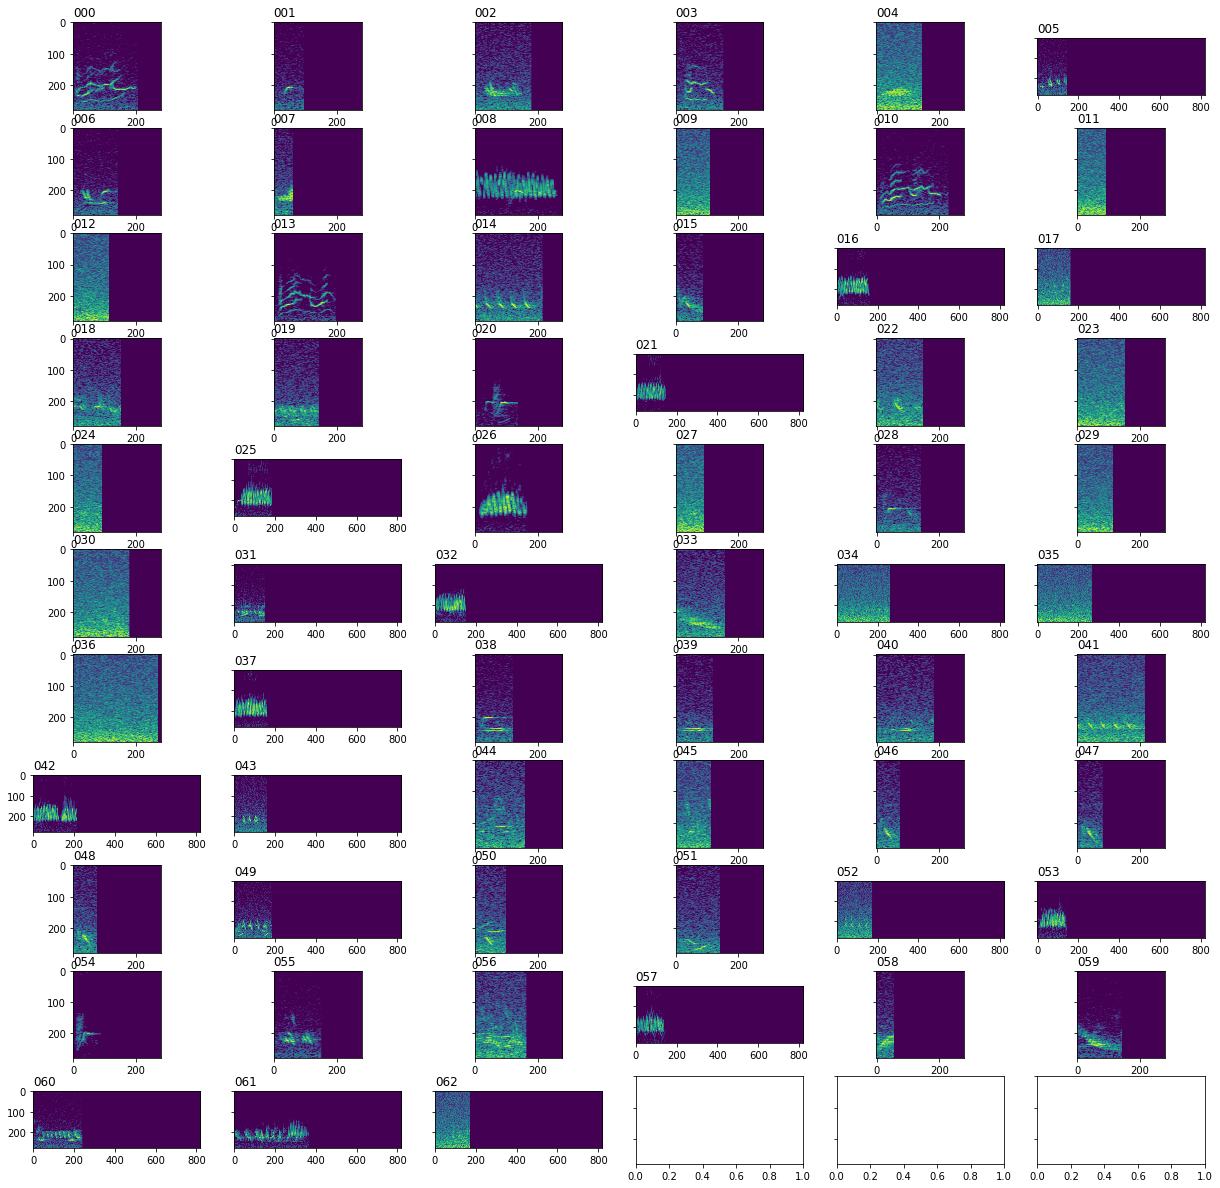

In [30]:
fig,axes = plt.subplots(11,6,figsize=(21,21),sharex=False,sharey=True)
for index,rec in snip_db.iterrows():
    idx = rec.name
    axy = idx // 6
    axx = idx % 6
    img = mpimg.imread(rec.spectra_path)
    axes[axy,axx].set_title(format(idx,'03d'),loc='left')
    axes[axy,axx].imshow(img)
figid = fig.canvas.mpl_connect('button_press_event',axes_click)

In [17]:
last_printed

NameError: name 'last_printed' is not defined